## Vision Transformer in Flax

In [1]:
import os
import sys

import jax
import jax.numpy as jnp
from jax import random

import flax
import flax.linen as nn
from flax.training import train_state, checkpoints

from tqdm.auto import tqdm

import optax

2023-05-18 21:19:35.571944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/arielg/anaconda3/envs/aistack/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import math
import json
from functools import partial
from PIL import Image
from collections import defaultdict

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

In [3]:
#Transformations applied on each image => bring them into a numpy array
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/tutorial15_jax"
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for training and validation
train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=8,
                               persistent_workers=True)
val_loader   = data.DataLoader(val_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)
test_loader  = data.DataLoader(test_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)

def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    x = x.reshape(B, -1, *x.shape[3:])   # [B, H'*W', p_H, p_W, C]
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1) # [B, H'*W', p_H*p_W*C]
    return x

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = train_set.dataset.classes
print(CIFAR_images.shape)
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)
# 4 images with each 64 patches of size (4,4,3)
print(img_patches.shape)
4*64*4*4*3

In [4]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

/tmp/ipykernel_84242/1754977528.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [6]:
def numpy_to_torch(array):
    array = jax.device_get(array)
    tensor = torch.from_numpy(array)
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

NUM_IMAGES = 4
CIFAR_images = np.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], axis=0)
img_grid = torchvision.utils.make_grid(numpy_to_torch(CIFAR_images),
                                       nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    x = x.reshape(B, -1, *x.shape[3:])   # [B, H'*W', p_H, p_W, C]
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1) # [B, H'*W', p_H*p_W*C]
    return x

img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

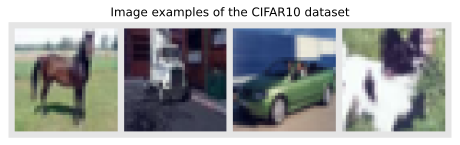

In [7]:
NUM_IMAGES = 4
CIFAR_images = np.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], axis=0)
img_grid = torchvision.utils.make_grid(numpy_to_torch(CIFAR_images),
                                       nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()

In [8]:
print("Device:", jax.devices()[0])

class AttentionBlock(nn.Module):
    embed_dim:int
    hidden_dim:int
    num_heads:int
    dropout_prob:float = 0.0
    
    def setup(self):
        self.layer_norm_1 = nn.LayerNorm()
        self.layer_norm_2 = nn.LayerNorm()
        self.dropout     = nn.Dropout(self.dropout_prob)
        self.attn        = nn.MultiHeadDotProductAttention(num_heads=self.num_heads)
        self.linear      = [
                            nn.Dense(self.hidden_dim),
                            nn.gelu,
                            nn.Dropout(self.dropout_prob),
                            nn.Dense(self.embed_dim)
                            ]
        
    def __call__(self, x, train=True):
        inp_x = self.layer_norm_1(x)
        attn_out = self.attn(inputs_q=inp_x, inputs_kv=inp_x)
        x = x + self.dropout(attn_out, deterministic=not train)
        
        linear_out = self.layer_norm_2(x)
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        print(f"x.shape: {x.shape}")
        return x

Device: gpu:0


In [ ]:
attnblock = AttentionBlock(
                            embed_dim=128,
                            hidden_dim=512,
                            num_heads=4,
                            dropout_prob=0.1
                        )
main_rng = random.PRNGKey(42)
main_rng, x_rng = random.split(main_rng)
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))

# initialize attention block parameters
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = attnblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']

In [ ]:
main_rng, dropout_apply_rng = random.split(main_rng)
out = attnblock.apply(
                        {'params': params}, 
                        x, 
                        train=True, 
                        rngs={'dropout': dropout_apply_rng}
                    )
print(f"main_rng: {main_rng}, dropout_apply_rng: {dropout_apply_rng}")
print(out.shape)

del attnblock, params

In [15]:
class VisionTransformer(nn.Module):
    embed_dim: int
    hidden_dim: int
    num_heads: int
    num_channels: int
    num_layers: int
    num_classes: int
    patch_size: int
    num_patches: int
    dropout_prob: float=0.0
    
    def setup(self):
        self.input_layer = nn.Dense(self.embed_dim)
        self.transformer = [
                                AttentionBlock(
                                    embed_dim=128,
                                    hidden_dim=512,
                                    num_heads=4,
                                    dropout_prob=0.1
                                ) for _ in range(self.num_layers)]
        self.mlp_head = nn.Sequential([nn.LayerNorm(), nn.Dense(self.num_classes)])
        self.dropout = nn.Dropout(self.dropout_prob)
        
        self.cls_token = self.param('cls_token', nn.initializers.normal(stddev=1.0),
                                    (1,1,self.embed_dim))
        self.pos_embedding = self.param('pos_embedding', nn.initializers.normal(stddev=1.0),
                                        (1,1+self.num_patches,self.embed_dim))
    def __call__(self, x, train=True):
        #Preprocess input
        x = img_to_patch(x, self.patch_size)
        print(f"patch size: {x.shape}")
        B,T,_ = x.shape
        x = self.input_layer(x)
        print(f"input_embed shape: {x.shape}")
        # Add CLS token and positional endoing
        cls_token = self.cls_token.repeat(B, axis=0) # repeat for batch
        print(f"clstoken: {self.cls_token.shape}")
        x = jnp.concatenate([cls_token, x], axis=1)
        x = x + self.pos_embedding[:,:T+1]
        
        # Apply transformer
        x = self.dropout(x, deterministic=not train)
        for attn_block in self.transformer:
            x = attn_block(x, train=train)
            
        
        # Perform classification pred
        cls = x[:,0]
        out = self.mlp_head(cls)
        
        return out

In [11]:
## Test VisionTransformer implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (5, 32, 32, 3))

# Initialize parameters of the Vision Transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = visntrans.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
rng = jax.random.PRNGKey(42)
rng, init_rng, dropout_init_rng = random.split(rng, 3)
out = visntrans.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)
print(out)
del visntrans, params

NameError: name 'main_rng' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


feat: 393216
label: 128


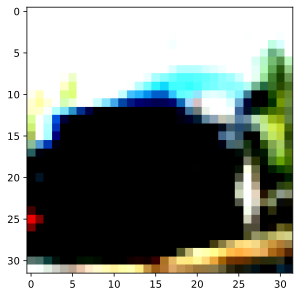

label: 1
patch size: (128, 64, 48)
input_embed shape: (128, 64, 128)
clstoken: [[[ 0.8654443   1.3679187  -1.6343538  -0.14977616  0.54276085
    0.7606997   1.3316509  -0.30787957 -0.86695856 -0.8420574
    0.62689     1.130988    1.5745671  -1.0514473   0.07245514
   -0.532058   -0.72313696 -0.8796558  -0.33451828 -1.5143796
    0.811065    1.0274619  -2.2071273  -0.17871952 -0.41523197
    1.0368391  -1.5826035   0.88394237  0.1416328   0.5676052
    0.15246357 -0.9801024  -0.4288781  -0.426231   -1.5344597
   -0.36818737  0.30277285 -3.5392208   1.859463   -1.2664045
   -0.12344054 -0.27051145 -0.41179252 -0.9416922   0.8397414
   -0.8312311  -0.26417187 -0.6637475   1.2354784   0.44401935
    0.29209685  0.9049613   0.9895666  -2.736854   -1.2889223
   -1.3479986  -1.3758969  -0.60248953 -0.67180914  0.17635524
    0.7899936   1.0214069   0.7329653   1.9329768  -0.77728516
   -2.4756587   1.0513369   0.68111455 -0.15951434 -0.36152795
   -1.3448342   0.22314383 -0.516584   -1.5053

Array([ 0.8455136 , -0.16989785,  0.18437979,  0.25809902,  0.8372168 ,
        0.9192903 ,  1.4560463 , -0.72161543, -0.16359827, -0.12177074],      dtype=float32)

In [14]:
main_rng = random.PRNGKey(42)

feats, labels = next(iter(train_loader))
print(f"feat: {feats.size}")
print(f"label: {labels.size}")
img = feats[0].squeeze()
label = labels[0]
main_rng, dropout_apply_rng = random.split(main_rng)
rng = jax.random.PRNGKey(42)
rng, init_rng, dropout_init_rng = random.split(rng, 3)
plt.imshow(img, cmap="gray")
plt.show()
print(f"label: {label}")

visntrans = VisionTransformer(embed_dim=128,
                              hidden_dim=512,
                              num_heads=4,
                              num_channels=3,
                              num_layers=6,
                              patch_size=4,
                              num_patches=64,
                              num_classes=10,
                              dropout_prob=0.1)

img_grid.shape
params = visntrans.init({'params': init_rng, 'dropout': dropout_init_rng}, feats, True)['params']
out = visntrans.apply({'params': params}, feats, train=True, rngs={'dropout': dropout_apply_rng})
out.shape
out[0]